In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# sklean imports 
from sklearn.linear_model import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import *

# Data import and cleaning 

In [2]:
# Data import
df_raw = pd.read_csv('48_Industry_Portfolios_Daily.csv', skiprows=range(0,9))
df_raw.drop(axis=0, labels=range(25292,len(df_raw)), inplace=True)

C:\Users\seanl\AppData\Local\Temp\ipykernel_16828\4267491402.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('48_Industry_Portfolios_Daily.csv', skiprows=range(0,9))


In [3]:
# Data cleaning 
df = df_raw.copy()
df = df.apply(pd.to_numeric)
df.rename(columns={'Unnamed: 0':'Date'}, inplace=True)

tmp = df.columns
tmp = list(tmp)

#--------------------------------------------------------------------------------------------------
# Column headers have random spaces, so i removed them 
out = []
for i in tmp:
    out.append(i.replace(' ', ''))

df.columns = out

# Changing date to actual date format 
df['Date'] = df['Date'].astype(str)
df['Date'] = df['Date'].apply(lambda x: (x[:4] + '-' + x[4:6] + '-' + x[6:]))
df['Date'] = pd.to_datetime(df['Date'])

df.head()
#df.info()

,Date,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
0,1926-07-01,0.56,-0.07,-99.99,-1.39,0.00,-1.44,0.62,-1.27,-0.90,...,-0.93,0.14,2.77,-0.02,0.27,0.59,0.47,0.81,0.57,-1.66
1,1926-07-02,0.29,0.06,-99.99,0.78,0.70,1.46,0.03,0.00,-0.34,...,1.07,0.07,0.00,0.01,-0.10,1.04,-0.03,-0.61,-1.03,3.09
2,1926-07-06,-0.33,0.18,-99.99,-1.74,0.50,-0.96,-0.06,4.27,-1.20,...,0.73,-0.20,0.77,-0.22,-0.67,0.45,0.31,-0.72,0.62,1.41
3,1926-07-07,3.57,-0.15,-99.99,-1.73,-0.12,-0.49,-0.06,-4.10,-0.22,...,2.22,0.18,-3.21,-0.57,-1.08,-1.09,0.21,0.07,0.17,0.62
4,1926-07-08,0.30,1.12,-99.99,-0.15,0.30,-0.49,0.24,0.00,-0.01,...,-0.39,0.46,-1.10,-0.38,0.33,0.99,-0.88,-0.36,-1.10,0.98


# Trying to get the correct min var portfolio 

In [4]:
# Selecting only the most recent 63 days 
date = '2022-01-03'
no_obj = 63
date_i = df[df['Date'] == date].index[0]

temp = df.copy()
temp = temp.iloc[date_i-63:date_i,:]
temp.shape

(63, 49)

In [5]:
# FOR TESTING 
temp = temp[['Agric', 'Food', 'Soda', 'Beer', 'Smoke', 'Toys']]
temp.head()

,Agric,Food,Soda,Beer,Smoke,Toys
25085,-2.01,0.10,-0.39,-0.35,0.57,-3.49
25086,1.91,0.75,0.51,0.36,-0.13,1.07
25087,-2.85,1.00,1.03,1.84,0.38,1.78
25088,1.04,-0.07,0.36,1.08,-0.63,2.05
25089,0.48,-0.48,0.09,-0.01,0.00,-1.04


In [6]:
# Use the first 63 as training data
R_train = temp
sc = StandardScaler(with_std = False)
R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])

In [7]:
arr_len = 6

# Getting y
eq_w = np.full(
    shape = arr_len,
    fill_value = 1/arr_len
)

y_train = np.dot(R_train, eq_w)

'''
print('Equal weight portfolio: {}'.format(eq_w))
print('\n')
print('y_train: {}'.format(y_train))
'''

"\nprint('Equal weight portfolio: {}'.format(eq_w))\nprint('\n')\nprint('y_train: {}'.format(y_train))\n"

In [8]:
# N matrix 
tmp1 = np.identity((arr_len-1), dtype='int64')
tmp2 = -np.ones((arr_len-1), dtype='int64')
N = np.append(tmp1,[tmp2], axis=0)

print(R_train.shape, N.shape)

# Calculate X
X_train = np.dot(R_train, N)

'''
print('N matrix: {}'.format(N))
print('\n')
print('X_train: {}'.format(X_train))
'''

(63, 6) (6, 5)


"\nprint('N matrix: {}'.format(N))\nprint('\n')\nprint('X_train: {}'.format(X_train))\n"

In [9]:
# Linear regression to get min var portfolio
reg = LinearRegression(fit_intercept = False)
reg.fit(X_train, y_train)

train_r2 = reg.score(X_train, y_train)
train_mse = mean_squared_error(y_train, reg.predict(X_train))

beta = reg.coef_
w = eq_w - np.dot(N,beta)

#--------------------------------------------------------------------------------------------------

'''
test_r2 = reg.score(X_test, y_test)
test_mse = mean_squared_error(y_test, ridge.predict(X_test))
'''

print(f'train_r2: {train_r2}')
print(f'train_mse: {train_mse}')
print('\n')

print(f'beta: {beta}')
print(f'w            : {[round(num, 3) for num in w]}')
print(f'Actual values: {str([-.002, -.004, .049, .514, .316, .128])}')

'''
print(test_r2)
print(test_mse)
'''

train_r2: 0.22247593212981887
train_mse: 0.46020583341227367


beta: [ 0.16927953  0.16834143  0.11724264 -0.34557298 -0.14832212]
w            : [-0.003, -0.002, 0.049, 0.512, 0.315, 0.128]
Actual values: [-0.002, -0.004, 0.049, 0.514, 0.316, 0.128]


'\nprint(test_r2)\nprint(test_mse)\n'

# Q1. Relationship between -log(alpha) and MSE

### Model fit scatter plot (to explain overfitting)

C:\Users\seanl\AppData\Local\Temp\ipykernel_16828\3768599628.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])
C:\Users\seanl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\seanl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an 

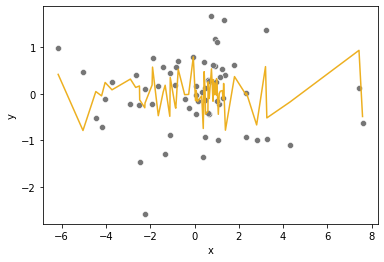

C:\Users\seanl\AppData\Local\Temp\ipykernel_16828\3768599628.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])
C:\Users\seanl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\seanl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an 

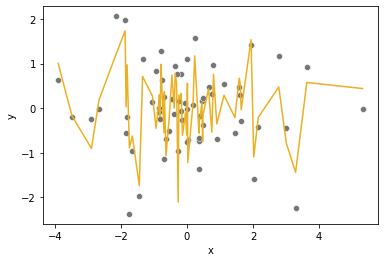

C:\Users\seanl\AppData\Local\Temp\ipykernel_16828\3768599628.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])
C:\Users\seanl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\seanl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an 

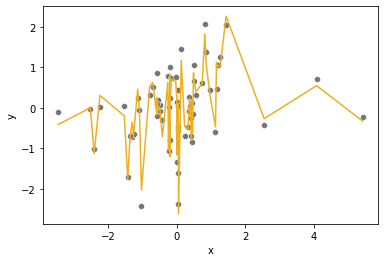

In [10]:
# Model fitter
def model_fitter(data, model):
    features = data.drop('y', axis = 1)
    target = data['y']
    model.fit(features, target)
    preds = model.predict(features)
    sns.scatterplot(data.x, data.y, color='#767676')
    sns.lineplot(data.x, preds, color='#edb021')
    plt.show()
    return model

#--------------------------------------------------------------------------------------------------
covariates = [6, 24, 48]


for cov_num in covariates:
    # This is all code to get the data into dataframe
    # Selecting the columns 
    temp = df.copy()
    temp = temp.iloc[:,1: cov_num+1]
    
    # Selecting training set
    date = '2022-01-03'
    no_obj = 63
    date_i = df[df['Date'] == date].index[0]

    R_train = temp.iloc[date_i-63:date_i,:]

    sc = StandardScaler(with_std = False)
    R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])

    #-------------------------------------------------------------------------------------------
    # Processing
    arr_len = cov_num
    # Getting y
    eq_w = np.full(
        shape = arr_len,
        fill_value = 1/arr_len
    )
    y_temp = np.dot(R_train, eq_w)

    # N matrix 
    tmp1 = np.identity((arr_len-1), dtype='int64')
    tmp2 = -np.ones((arr_len-1), dtype='int64')
    N = np.append(tmp1,[tmp2], axis=0)
    
    # Calculate X
    X_temp = np.dot(R_train, N)

    #-------------------------------------------------------------------------------------------
    temp_df = pd.DataFrame(X_temp)
    temp_df.columns = ['X' + str(i) for i in temp_df.columns]
    temp_df.insert(1, 'y', y_temp)
    temp_df = temp_df.rename({'X0':'x'}, axis=1)
    
    lm = model_fitter(temp_df, LinearRegression())



#lm = model_fitter(temp_df, LinearRegression())

In [11]:
# Selecting the columns 
q1 = df.copy()
q1 = q1[['Trans', 'Hshld', 'Guns', 'LabEq', 'Fin', 'Hlth']]
q1.head()

,Trans,Hshld,Guns,LabEq,Fin,Hlth
0,0.14,-0.90,-99.99,0.00,0.57,-99.99
1,0.07,-0.34,-99.99,1.80,-1.03,-99.99
2,-0.20,-1.20,-99.99,0.66,0.62,-99.99
3,0.18,-0.22,-99.99,-0.66,0.17,-99.99
4,0.46,-0.01,-99.99,0.33,-1.10,-99.99


In [12]:
# Selecting training set
date = '2022-01-03'
no_obj = 63
date_i = df[df['Date'] == date].index[0]

R_train = q1.iloc[date_i-63:date_i,:]

sc = StandardScaler(with_std = False)
R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])

R_train.shape

C:\Users\seanl\AppData\Local\Temp\ipykernel_16828\3357644515.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])


(63, 6)

In [13]:
# Selecting the test set (dates after the 1 day in 2022)
date = '2022-01-03'
no_obj = int(63 / .7 * .3)
date_i = df[df['Date'] == date].index[0]

R_test = q1.iloc[date_i:date_i+no_obj,:]

sc = StandardScaler(with_std = False)
R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])

R_test.shape

C:\Users\seanl\AppData\Local\Temp\ipykernel_16828\38191106.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])


(27, 6)

### Ridge

In [14]:
arr_len = 6

# y values
eq_w = np.full(
    shape = arr_len,
    fill_value = 1/arr_len
)

y_train = np.dot(R_train, eq_w)
y_test = np.dot(R_test, eq_w)

#--------------------------------------------------------------------------------------------------

# X values
tmp1 = np.identity((arr_len-1), dtype='int64')
tmp2 = -np.ones((arr_len-1), dtype='int64')
N = np.append(tmp1,[tmp2], axis=0)

X_train = np.dot(R_train, N)
X_test = np.dot(R_test, N)

'''
print('y_train: {}'.format(y_train))
print('y_test: {}'.format(y_test))
print('\n')
print('X_train: {}'.format(X_train))
print('X_test: {}'.format(X_test))
'''

"\nprint('y_train: {}'.format(y_train))\nprint('y_test: {}'.format(y_test))\nprint('\n')\nprint('X_train: {}'.format(X_train))\nprint('X_test: {}'.format(X_test))\n"

In [15]:
alpha_vec = np.logspace(-10,3,100)

# results list 
train_r2 = []
train_mse = []
coeff_dict = {}

test_r2 = []
test_mse = []

for cur_alpha in alpha_vec:
    ridge = Ridge(cur_alpha)
    ridge.fit(X_train, y_train)
    
    # Training
    train_r2.append(ridge.score(X_train, y_train))
    train_mse.append(mean_squared_error(y_train, ridge.predict(X_train)))
    coeff_dict[cur_alpha] = ridge.coef_
    
    # Test 
    test_r2.append(ridge.score(X_test, y_test))
    test_mse.append(mean_squared_error(y_test, ridge.predict(X_test)))
    


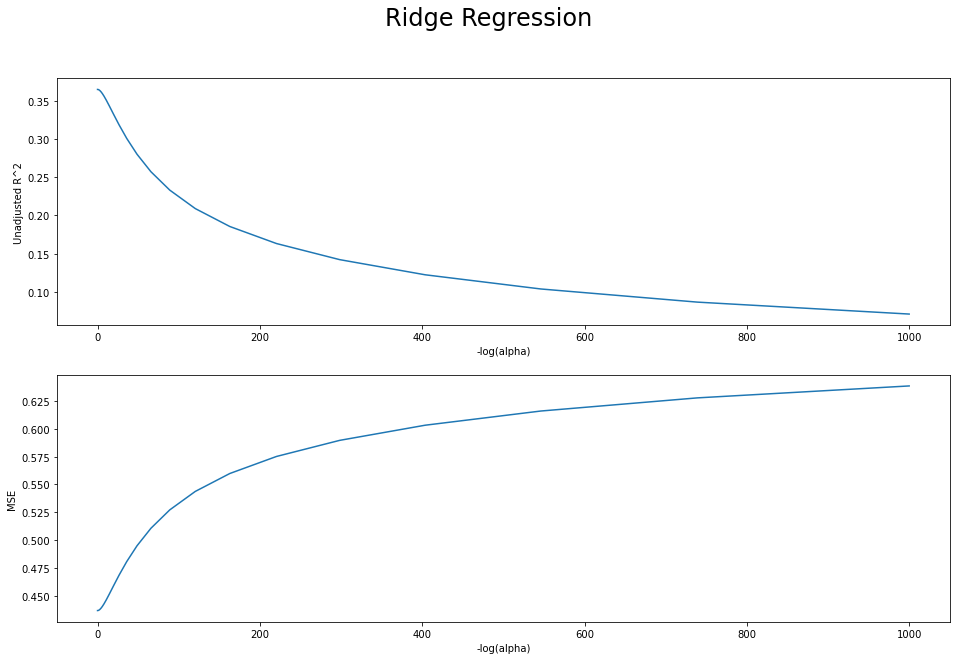

In [16]:
# r2 and mse plots for training 
fig, axs = plt.subplots(nrows=2, figsize=(16,10))
sns.lineplot(x=alpha_vec, y=np.array(train_r2), ax=axs[0])
axs[0].set(xlabel='-log(alpha)', ylabel='Unadjusted R^2')

sns.lineplot(x=alpha_vec, y=np.array(train_mse), ax=axs[1])
axs[1].set(xlabel='-log(alpha)', ylabel='MSE')

fig.suptitle('Ridge Regression', fontsize = 24)

plt.show()

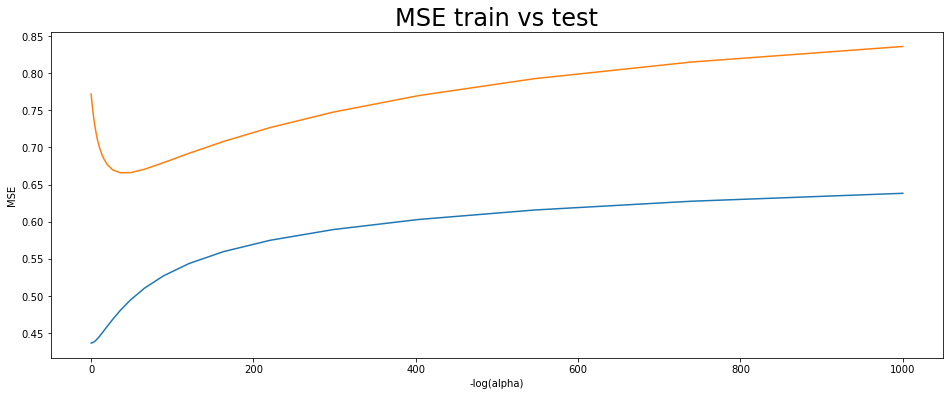

In [17]:
# mse plots for training vs test 
plt.figure(figsize=(16,6))
fig1 = sns.lineplot(x=alpha_vec, y=np.array(train_mse))
fig1 = sns.lineplot(x=alpha_vec, y=np.array(test_mse))
fig1.set(xlabel='-log(alpha)', ylabel='MSE')
plt.title('MSE train vs test', fontsize = 24)

plt.show()

### Lasso

In [18]:
alpha_vec = np.logspace(-10,0,100)

# results list 
train_r2 = []
train_mse = []
coeff_dict = {}

test_r2 = []
test_mse = []


# iterate over all alphas in range
for cur_alpha in alpha_vec:
    lasso = Lasso(cur_alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    
    # Training
    train_r2.append(lasso.score(X_train, y_train))
    train_mse.append(mean_squared_error(y_train, lasso.predict(X_train)))
    coeff_dict[cur_alpha] = ridge.coef_
    
    # Test 
    test_r2.append(lasso.score(X_test, y_test))
    test_mse.append(mean_squared_error(y_test, lasso.predict(X_test)))

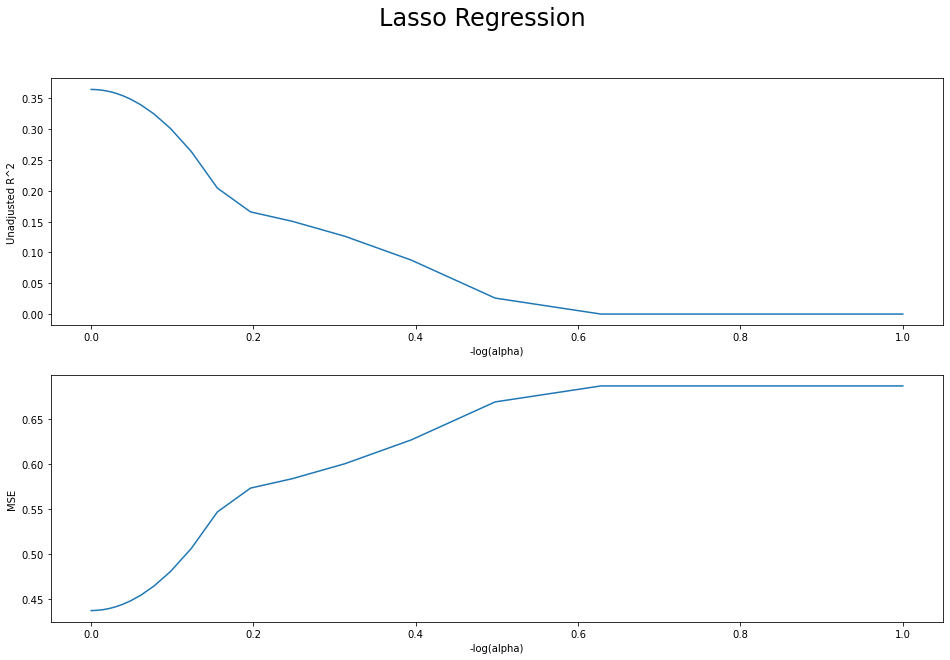

In [19]:
# r2 and mse plots for training 
fig, axs = plt.subplots(nrows=2, figsize=(16,10))
sns.lineplot(x=alpha_vec, y=np.array(train_r2), ax=axs[0])
axs[0].set(xlabel='-log(alpha)', ylabel='Unadjusted R^2')

sns.lineplot(x=alpha_vec, y=np.array(train_mse), ax=axs[1])
axs[1].set(xlabel='-log(alpha)', ylabel='MSE')

fig.suptitle('Lasso Regression', fontsize = 24)

plt.show()

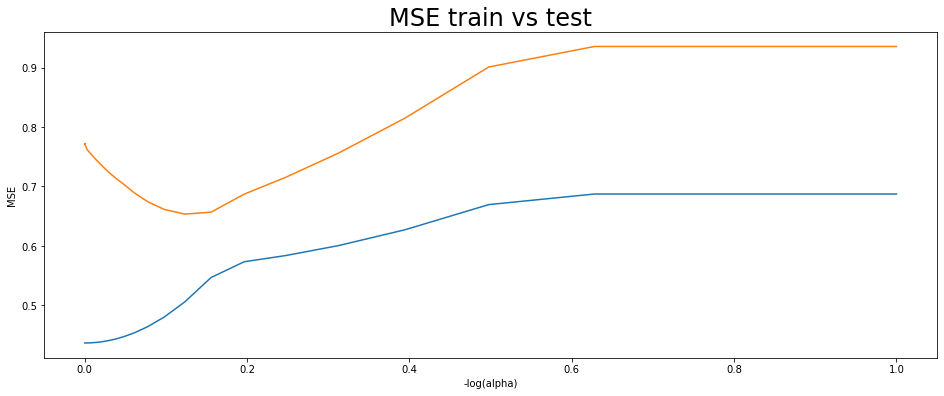

In [20]:
# mse plots for training vs test 
plt.figure(figsize=(16,6))
fig1 = sns.lineplot(x=alpha_vec, y=np.array(train_mse))
fig1 = sns.lineplot(x=alpha_vec, y=np.array(test_mse))
fig1.set(xlabel='-log(alpha)', ylabel='MSE')
plt.title('MSE train vs test', fontsize = 24)

plt.show()

# Cross Validation (I havent done the demean!)

### Ridge

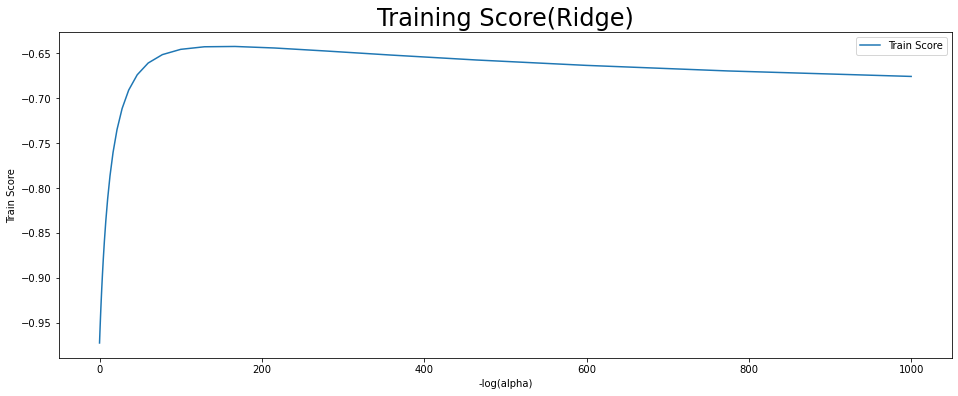

ridge alpha: 215.44346900318777
Test set MSE: 0.7252818493102308
Test set Rsq: 0.2247586866565474


In [21]:
alpha_vec = np.logspace(-8,3,100)


cvResults = []

# iterate over all alphas in range
for cur_alpha in alpha_vec:
    clf_cv = Ridge(cur_alpha)
    
    # Perform 10-fold cross validation 
    scores = cross_val_score(estimator = clf_cv, X = X_train, y = y_train, cv = 10, \
                             scoring = 'neg_mean_squared_error', n_jobs = 4)
    
    cvResults.append(scores.mean())

#--------------------------------------------------------------------------------------------------

# Graph
plt.figure(figsize=(16,6))
fig2 = sns.lineplot(y = cvResults, x = alpha_vec, label = "Train Score")
plt.title('Training Score(Ridge)', fontsize = 24)
fig2.set(xlabel='-log(alpha)', ylabel='Train Score')
plt.show()

#--------------------------------------------------------------------------------------------------

# Stats
ridgecv = RidgeCV(alphas = alpha_vec, scoring = 'neg_mean_squared_error')
ridgecv.fit(X_train, y_train)
ridge_best_alpha = ridgecv.alpha_
print('ridge alpha: {}'.format(ridgecv.alpha_))

# refit on full dataset with optimized parameter
opt_ridge = Ridge(alpha = ridgecv.alpha_)
opt_ridge.fit(X_train, y_train)

# assess on test set
print('Test set MSE: {}'.format(mean_squared_error(y_test, opt_ridge.predict(X_test))))
print('Test set Rsq: {}'.format(r2_score(y_test, opt_ridge.predict(X_test))))

### Lasso

In [ ]:
alpha_vec = np.logspace(-8,0,100)

cvResults = []

for cur_alpha in alpha_vec:
    clf_cv = Lasso(cur_alpha)
    
    # Perform 10-fold cross validation 
    scores = cross_val_score(estimator = clf_cv, X = X_train, y = y_train, cv = 10, \
                             scoring = 'neg_mean_squared_error', n_jobs = 4)
    
    # Attach results
    cvResults.append(scores.mean())

#--------------------------------------------------------------------------------------------------

# Graph
plt.figure(figsize=(16,6))
fig2 = sns.lineplot(y = cvResults, x = alpha_vec, label = "Train Score")
plt.title('Training Score(Lasso)', fontsize = 24)
fig2.set(xlabel='-log(alpha)', ylabel='Train Score')
plt.show()

#--------------------------------------------------------------------------------------------------

# Stats
lassocv = LassoCV(alphas = alpha_vec, max_iter=10000)
lassocv.fit(X_train, y_train)
lasso_best_alpha = lassocv.alpha_
print(f'alpha: {lassocv.alpha_}')

# refit on full dataset with optimized parameter
opt_lasso = Lasso(alpha = lassocv.alpha_)
opt_lasso.fit(X_train, y_train)

# assess on test set
print(f'Test set MSE: {mean_squared_error(y_test, opt_lasso.predict(X_test))}')
print(f'Test set Rsq: {r2_score(y_test, opt_lasso.predict(X_test))}')

# Q2. Repeat the above procedure for 24 as well as 48 industries

### Ridge (24 industry)

In [ ]:
q2_24 = df.copy()
q2_24 = q2_24[['Drugs', 'LabEq', 'Clths', 'Aero', 'RlEst', 'Mach', 'Beer', 'Hshld', 'Insur',
               'Autos', 'Rubbr', 'BusSv', 'Util', 'Hlth', 'Books', 'Comps', 'Smoke', 'Fin',
               'Agric', 'Oil', 'Chips', 'Soda', 'PerSv', 'BldMt']]

# Selecting training set
date = '2022-01-03'
no_obj = 63
date_i = df[df['Date'] == date].index[0]

R_train = q2_24.iloc[date_i-63:date_i,:]

sc = StandardScaler(with_std = False)
R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])


# Selecting the test set (dates after the 1 day in 2022)
date = '2022-01-03'
no_obj = int(63 / .7 * .3)
date_i = df[df['Date'] == date].index[0]

R_test = q2_24.iloc[date_i:date_i+no_obj,:]

sc = StandardScaler(with_std = False)
R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])

print(f'Training set shape: {R_train.shape}')
print(f'Test set shape: {R_test.shape}')

arr_len = 24

# y values
eq_w = np.full(
    shape = arr_len,
    fill_value = 1/arr_len
)

y_train = np.dot(R_train, eq_w)
y_test = np.dot(R_test, eq_w)


# X values
tmp1 = np.identity((arr_len-1), dtype='int64')
tmp2 = -np.ones((arr_len-1), dtype='int64')
N = np.append(tmp1,[tmp2], axis=0)

X_train = np.dot(R_train, N)
X_test = np.dot(R_test, N)

'''
print('y_train: {}'.format(y_train))
print('y_test: {}'.format(y_test))
print('\n')
print('X_train: {}'.format(X_train))
print('X_test: {}'.format(X_test))
'''

# Model fitting
alpha_vec = np.logspace(-8,3,100)

train_r2_24 = []
train_mse_24 = []
coeff_dict_24 = {}

test_r2_24 = []
test_mse_24 = []

for cur_alpha in alpha_vec:
    ridge = Ridge(cur_alpha)
    ridge.fit(X_train, y_train)
    
    # Training
    train_r2_24.append(ridge.score(X_train, y_train))
    train_mse_24.append(mean_squared_error(y_train, ridge.predict(X_train)))
    coeff_dict_24[cur_alpha] = ridge.coef_
    
    # Test 
    test_r2_24.append(ridge.score(X_test, y_test))
    test_mse_24.append(mean_squared_error(y_test, ridge.predict(X_test)))


### Ridge (48 industry)

In [ ]:
q2_48 = df.copy()
q2_48 = q2_48.iloc[:,1:]

# Selecting training set
date = '2022-01-03'
no_obj = 63
date_i = df[df['Date'] == date].index[0]

R_train = q2_48.iloc[date_i-63:date_i,:]

sc = StandardScaler(with_std = False)
R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])


# Selecting the test set (dates after the 1 day in 2022)
date = '2022-01-03'
no_obj = int(63 / .7 * .3)
date_i = df[df['Date'] == date].index[0]

R_test = q2_48.iloc[date_i:date_i+no_obj,:]

sc = StandardScaler(with_std = False)
R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])

print(f'Training set shape: {R_train.shape}')
print(f'Test set shape: {R_test.shape}')

arr_len = 48

# y values
eq_w = np.full(
    shape = arr_len,
    fill_value = 1/arr_len
)

y_train = np.dot(R_train, eq_w)
y_test = np.dot(R_test, eq_w)


# X values
tmp1 = np.identity((arr_len-1), dtype='int64')
tmp2 = -np.ones((arr_len-1), dtype='int64')
N = np.append(tmp1,[tmp2], axis=0)

X_train = np.dot(R_train, N)
X_test = np.dot(R_test, N)

'''
print('y_train: {}'.format(y_train))
print('y_test: {}'.format(y_test))
print('\n')
print('X_train: {}'.format(X_train))
print('X_test: {}'.format(X_test))
'''

# Model fitting
alpha_vec = np.logspace(-8,3,100)

train_r2_48 = []
train_mse_48 = []
coeff_dict_48 = {}

test_r2_48 = []
test_mse_48 = []

for cur_alpha in alpha_vec:
    ridge = Ridge(cur_alpha)
    ridge.fit(X_train, y_train)
    
    # Training
    train_r2_48.append(ridge.score(X_train, y_train))
    train_mse_48.append(mean_squared_error(y_train, ridge.predict(X_train)))
    coeff_dict_48[cur_alpha] = ridge.coef_
    
    # Test 
    test_r2_48.append(ridge.score(X_test, y_test))
    test_mse_48.append(mean_squared_error(y_test, ridge.predict(X_test)))


In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(16,10))
sns.lineplot(x=alpha_vec, y=np.array(train_mse_24), ax=axs[0])
sns.lineplot(x=alpha_vec, y=np.array(test_mse_24), ax=axs[0])
axs[0].set(xlabel='-log(alpha)', ylabel='MSE')


sns.lineplot(x=alpha_vec, y=np.array(train_mse_48), ax=axs[1])
sns.lineplot(x=alpha_vec, y=np.array(test_mse_48), ax=axs[1])
axs[1].set(xlabel='-log(alpha)', ylabel='MSE')


fig.suptitle('Ridge Regression 24 vs 48 industry', fontsize = 24)


plt.show()

### Lasso (24 industry)

In [ ]:
q2_24 = df.copy()
q2_24 = q2_24[['Drugs', 'LabEq', 'Clths', 'Aero', 'RlEst', 'Mach', 'Beer', 'Hshld', 'Insur',
               'Autos', 'Rubbr', 'BusSv', 'Util', 'Hlth', 'Books', 'Comps', 'Smoke', 'Fin',
               'Agric', 'Oil', 'Chips', 'Soda', 'PerSv', 'BldMt']]

# Selecting training set
date = '2022-01-03'
no_obj = 63
date_i = df[df['Date'] == date].index[0]

R_train = q2_24.iloc[date_i-63:date_i,:]

sc = StandardScaler(with_std = False)
R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])


# Selecting the test set (dates after the 1 day in 2022)
date = '2022-01-03'
no_obj = int(63 / .7 * .3)
date_i = df[df['Date'] == date].index[0]

R_test = q2_24.iloc[date_i:date_i+no_obj,:]

sc = StandardScaler(with_std = False)
R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])

print(f'Training set shape: {R_train.shape}')
print(f'Test set shape: {R_test.shape}')

arr_len = 24

# y values
eq_w = np.full(
    shape = arr_len,
    fill_value = 1/arr_len
)

y_train = np.dot(R_train, eq_w)
y_test = np.dot(R_test, eq_w)


# X values
tmp1 = np.identity((arr_len-1), dtype='int64')
tmp2 = -np.ones((arr_len-1), dtype='int64')
N = np.append(tmp1,[tmp2], axis=0)

X_train = np.dot(R_train, N)
X_test = np.dot(R_test, N)

'''
print('y_train: {}'.format(y_train))
print('y_test: {}'.format(y_test))
print('\n')
print('X_train: {}'.format(X_train))
print('X_test: {}'.format(X_test))
'''

# Model fitting
alpha_vec = np.logspace(-8,0,100)

train_r2_24 = []
train_mse_24 = []
coeff_dict_24 = {}

test_r2_24 = []
test_mse_24 = []

for cur_alpha in alpha_vec:
    lasso = Lasso(cur_alpha)
    lasso.fit(X_train, y_train)
    
    # Training
    train_r2_24.append(lasso.score(X_train, y_train))
    train_mse_24.append(mean_squared_error(y_train, lasso.predict(X_train)))
    coeff_dict_24[cur_alpha] = lasso.coef_
    
    # Test 
    test_r2_24.append(lasso.score(X_test, y_test))
    test_mse_24.append(mean_squared_error(y_test, lasso.predict(X_test)))

### Ridge (48 industry)

In [ ]:
q2_48 = df.copy()
q2_48 = q2_48.iloc[:,1:]

# Selecting training set
date = '2022-01-03'
no_obj = 63
date_i = df[df['Date'] == date].index[0]

R_train = q2_48.iloc[date_i-63:date_i,:]

sc = StandardScaler(with_std = False)
R_train[R_train.columns] = sc.fit_transform(R_train[R_train.columns])


# Selecting the test set (dates after the 1 day in 2022)
date = '2022-01-03'
no_obj = int(63 / .7 * .3)
date_i = df[df['Date'] == date].index[0]

R_test = q2_48.iloc[date_i:date_i+no_obj,:]

sc = StandardScaler(with_std = False)
R_test[R_test.columns] = sc.fit_transform(R_test[R_test.columns])

print(f'Training set shape: {R_train.shape}')
print(f'Test set shape: {R_test.shape}')

arr_len = 48

# y values
eq_w = np.full(
    shape = arr_len,
    fill_value = 1/arr_len
)

y_train = np.dot(R_train, eq_w)
y_test = np.dot(R_test, eq_w)


# X values
tmp1 = np.identity((arr_len-1), dtype='int64')
tmp2 = -np.ones((arr_len-1), dtype='int64')
N = np.append(tmp1,[tmp2], axis=0)

X_train = np.dot(R_train, N)
X_test = np.dot(R_test, N)

'''
print('y_train: {}'.format(y_train))
print('y_test: {}'.format(y_test))
print('\n')
print('X_train: {}'.format(X_train))
print('X_test: {}'.format(X_test))
'''

# Model fitting
alpha_vec = np.logspace(-8,0,100)

train_r2_48 = []
train_mse_48 = []
coeff_dict_48 = {}

test_r2_48 = []
test_mse_48 = []

for cur_alpha in alpha_vec:
    lasso = Lasso(cur_alpha)
    lasso.fit(X_train, y_train)
    
    # Training
    train_r2_48.append(lasso.score(X_train, y_train))
    train_mse_48.append(mean_squared_error(y_train, lasso.predict(X_train)))
    coeff_dict_48[cur_alpha] = lasso.coef_
    
    # Test 
    test_r2_48.append(lasso.score(X_test, y_test))
    test_mse_48.append(mean_squared_error(y_test, lasso.predict(X_test)))

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(16,10))
sns.lineplot(x=alpha_vec, y=np.array(train_mse_24), ax=axs[0])
sns.lineplot(x=alpha_vec, y=np.array(test_mse_24), ax=axs[0])
axs[0].set(xlabel='-log(alpha)', ylabel='MSE')


sns.lineplot(x=alpha_vec, y=np.array(train_mse_48), ax=axs[1])
sns.lineplot(x=alpha_vec, y=np.array(test_mse_48), ax=axs[1])
axs[1].set(xlabel='-log(alpha)', ylabel='MSE')


fig.suptitle('Lasso Regression 24 vs 48 industry', fontsize = 24)


plt.show()